In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True

def my_obj(preds, train_data):
    labels = train_deata.get_label()
    

train = pd.read_csv('../data/public_raw.train.csv')
test = pd.read_csv('../data/public_raw.test.csv')

train_len = train.shape[0]

train['is_train']=1
test['is_train']=0

df = pd.concat([train, test],sort=False)

df.rename(index=str, columns=rep_cols, inplace=True)

In [4]:
#异常值处理
# 改用均值
correct_dict = {
    'V_A':(600,700),
    'V_B':(600,700),
    'V_C':(600,700),
    'P_A':(0,10000),
    'P_B':(0,10000),
    'P_C':(0,10000),
    'P_avg':(0,10000)
}
cols = [c for c in df.columns.tolist() if c!='y' and c!='ID']
for c in correct_dict.keys():
    df[c+'_is_out_of_upper'] = (df[c]>correct_dict[c][1]).astype(np.int32)
    df[c+'_is_out_of_lower'] = (df[c]<correct_dict[c][0]).astype(np.int32)
#     df.loc[(df[c]>df[c].quantile(0.99))|(df[c]<df[c].quantile(0.01)),c]=np.nan
#     df[c].fillna(df[c].mean(),inplace=True)
#     df[c] = np.clip(df[c],df[c].quantile(.01),df[c].quantile(0.99))
#     df[c] = np.clip(df[c], correct_dict[c][0], correct_)

In [5]:
df.head()

,ID,board_t,env_t,light_strength,efficiency,efficiency_A,efficiency_B,efficiency_C,V_A,V_B,...,V_C_is_out_of_upper,V_C_is_out_of_lower,P_A_is_out_of_upper,P_A_is_out_of_lower,P_B_is_out_of_upper,P_B_is_out_of_lower,P_C_is_out_of_upper,P_C_is_out_of_lower,P_avg_is_out_of_upper,P_avg_is_out_of_lower
0,10,-19.14,-17.4,34,80.55,106.32,16.98,118.36,729,709,...,1,0,0,0,0,0,0,0,0,0
1,11,-18.73,-17.3,30,99.90,139.00,21.20,139.51,728,717,...,1,0,0,0,0,0,0,0,0,0
2,12,-17.54,-17.0,41,82.48,114.86,14.91,117.66,731,722,...,1,0,0,0,0,0,0,0,0,0
3,14,-15.43,-16.6,53,73.98,101.72,15.55,104.67,730,727,...,1,0,0,0,0,0,0,0,0,0
4,15,-14.60,-16.3,65,64.62,86.86,13.09,93.92,727,729,...,1,0,0,0,0,0,0,0,0,0


In [8]:
df.sort_values(by=['ID'],ascending=True, inplace=True)

In [9]:
df.reset_index(drop=True, inplace=True)

In [13]:
next_one = []
prev_one = []
next_id = []
prev_id = []
next_b_t = []
prev_b_t = []
next_t = []
prev_t = []
next_ls = []
prev_ls = []

df_len = df.shape[0]

i_y =df.columns.get_loc("y")
i_ls = df.columns.get_loc("light_strength")

for i in range(df_len):
    prev = i-1
    while(prev>=0 and df.iat[prev,i_y]<0):
        prev-=1
    if prev>=0:
        prev_one.append(df.iat[prev,i_y])
        prev_id.append(prev)
        prev_ls.append(df.iat[prev,i_ls])
    else:
        prev_one.append(np.nan)
        prev_id.append(0)
        prev_ls.append(0)
        
    next = i+1
    while(next<df_len and df.iat[next,i_y]<0):
        next+=1
    if next<df_len:
        next_one.append(df.iat[next,i_y])
        next_id.append(next)
        next_ls.append(df.iat[next,i_ls])
    else:
        next_one.append(np.nan)
        next_id.append(df_len)
        next_ls.append(0)

In [46]:
df['next_value'] = next_one
df['prev_value'] = prev_one
df['avg_value'] = np.nanmean([df['next_value'], df['prev_value']],axis=0)
df['next_ID'] = next_id
df['prev_ID'] = prev_id
df['next_ls'] = next_ls
df['prev_ls'] = prev_ls
df['interpolation_ID'] = df['prev_value']+(df['ID']-df['prev_ID'])/(df['next_ID']-df['prev_ID'])*(df['next_value']-df['prev_value'])
df['interpolation_ls'] = df['prev_value']+(df['light_strength']-df['prev_ls'])/(1.5+df['next_ls']-df['prev_ls'])*(df['next_value']-df['prev_value'])

In [15]:
target = ['P_A','P_avg','I_A','P_C','I_C','P_B','I_B']
target_plus = [c+'_is_out_of_upper' for c in target]+[c+'_is_out_of_lower' for c in target]+target
for c in target:
    df['log_'+c] = np.log1p(df[c])

# 估算功率
df['predict_p_1'] = df['P_A']+df['P_B']+df['P_C']
df['predict_p_2'] = (df['P_A']*df['efficiency_A'] \
                   +df['P_B']*df['efficiency_B'] \
                   +df['P_C']*df['efficiency_C'])/36000

# 第一阶，用其他值预测某些特征

params_layer1 = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'num_leaves': 48,
    'learning_rate': 0.2,
#     'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}
kf_layer1 = KFold(3, shuffle=True, random_state=1991)

layer1_result = df[['ID']]

for t in target:
    print('Now, we are processing',t)
    # 特征中去掉t
    predictor_t = [c for c in target_plus if c not in['ID','y',t,t+'_is_out_of_upper',t+'_is_out_of_lower']]
    
    # 初始化结果
    val_preds = np.zeros(df.shape[0])
    
    for n_fold, (tra_idx, val_idx) in enumerate(kf_layer1.split(df)):
        tra = df.iloc[tra_idx]
        # 删掉有问题的数据
        tra.drop(tra[(tra[t+'_is_out_of_upper']==1)|(tra[t+'_is_out_of_lower']==1)].index, inplace=True)
        
        val = df.iloc[val_idx]
        # 删掉有问题的数据
        val_c = val.drop(val[(val[t+'_is_out_of_upper']==1)|(val[t+'_is_out_of_lower']==1)].index)

        train_set = lightgbm.Dataset(
            tra[predictor_t],
            tra[t]
        )

        validation_set = lightgbm.Dataset(
            val_c[predictor_t],
            val_c[t]
        )

        model = lightgbm.train(params_layer1, train_set, 
                               num_boost_round=8000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=20,
                              verbose_eval=1000)

        val_preds[val_idx] = model.predict(val[predictor_t])
        
    # 将结果保存起来
    layer1_result['predicted_'+t] = val_preds

In [14]:
layer1_result.to_pickle('../feature/predicted_value-2.pkl')

In [18]:
layer1_result = pd.read_pickle('../feature/predicted_value.pkl')

In [15]:
df = df.merge(layer1_result, on='ID', how='left')

In [16]:
for t in target:
    df['diff_'+t] = df[t]-df['predicted_'+t]

In [23]:
df['magic_feature'] = df['ID']%190

In [47]:
# train = df.iloc[0:train_len]
# test = df.iloc[train_len:]
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [48]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}

predictor = [c for c in train.columns.tolist() if c not in['y','is_train']]

In [49]:
test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(test[predictor]))
        
#         train_set = lightgbm.Dataset(
#             tra[predictor],
#             np.log1p(tra['y'])
#         )

#         validation_set = lightgbm.Dataset(
#             val[predictor],
#             np.log1p(val['y'])
#         )

#         model = lightgbm.train(params, train_set, num_boost_round=5000,
#                               valid_sets= [validation_set],
#                               valid_names=['valid'],
#                               early_stopping_rounds=100,
#                                feval=my_val,
#                               verbose_eval=500)

#         val_preds[idx][val_idx] = np.expm1(model.predict(val[predictor]))
#         test_predicts.append(np.expm1(model.predict(test[predictor])))


print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0562015	valid's score: 0.808363
Early stopping, best iteration is:
[562]	valid's l2: 0.0561299	valid's score: 0.808461
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0193845	valid's score: 0.877787
Early stopping, best iteration is:
[510]	valid's l2: 0.0192942	valid's score: 0.878037
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[161]	valid's l2: 0.0136733	valid's score: 0.895309
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0390349	valid's score: 0.835022
[1000]	valid's l2: 0.0374865	valid's score: 0.837792
Early stopping, best iteration is:
[1171]	valid's l2: 0.0373576	valid's score: 0.838025
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[372]	valid's l2: 0.016334	valid's score: 0.886678
Training until validation scores don't im

In [80]:
print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

local cv: 0.8590894080898801


In [50]:
train.head(10)

,ID,board_t,env_t,light_strength,efficiency,efficiency_A,efficiency_B,efficiency_C,V_A,V_B,...,next_value,prev_value,avg_value,next_ID,prev_ID,next_ls,prev_ls,interpolation_ID,interpolation_ls,magic_feature
2,10,-19.14,-17.4,34,80.55,106.32,16.98,118.36,729,709,...,1.692575,NaN,1.692575,3,0,30,0,NaN,NaN,10
3,11,-18.73,-17.3,30,99.90,139.00,21.20,139.51,728,717,...,1.975787,1.437752,1.706770,4,2,41,34,3.858913,1.184558,11
4,12,-17.54,-17.0,41,82.48,114.86,14.91,117.66,731,722,...,2.370656,1.692575,2.031615,6,3,53,30,3.726817,1.997019,12
6,14,-15.43,-16.6,53,73.98,101.72,15.55,104.67,730,727,...,2.532091,1.975787,2.253939,7,4,65,41,3.830134,2.237578,14
7,15,-14.60,-16.3,65,64.62,86.86,13.09,93.92,727,729,...,2.779719,2.370656,2.575187,8,6,76,53,4.211441,2.571013,15
8,16,-14.10,-16.2,76,61.97,77.59,25.80,82.53,733,728,...,3.832378,2.532091,3.182235,11,7,96,65,5.457736,2.972188,16
11,19,-11.25,-15.9,96,71.51,70.09,70.09,74.35,726,726,...,3.956692,2.779719,3.368205,12,8,100,76,6.016394,3.702835,19
12,20,-10.77,-15.8,100,70.04,69.27,68.43,72.42,726,720,...,5.440741,3.832378,4.636559,14,11,100,96,8.657466,5.002096,20
14,22,-10.77,-15.8,100,5699.37,16924.86,162.65,10.59,65382,7,...,4.501339,3.956692,4.229016,16,12,122,100,5.318310,3.956692,22
16,24,-8.33,-14.7,122,63.99,62.47,62.96,66.53,721,717,...,5.135805,5.440741,5.288273,19,14,142,100,4.830870,5.286520,24


In [32]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False).head(20)

P_A                 213281.614781
I_A                  78626.754818
I_C                  55108.540367
P_avg                42837.628159
avg_value            19909.648506
P_C                  17879.467202
P_B                  11791.316512
I_B                   7289.793923
prev_value            1451.447198
interpolation_ls       735.324104
light_strength         246.287412
next_value             160.978217
efficiency_C           121.560562
prev_ls                107.647241
board_t                107.057531
V_B                    106.715245
efficiency              97.737557
wind_direction          97.379456
V_A                     85.196419
wind_speed              59.659514
dtype: float64

In [82]:
train.interpolation_ls.describe()

count    8959.000000
mean             NaN
std              NaN
min             -inf
25%         2.416154
50%         5.698367
75%         8.928873
max              inf
Name: interpolation_ls, dtype: float64

In [26]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False).head(20)

P_A               177424.003579
log_P_A           123218.987586
P_avg              38730.925607
I_A                37315.842299
predict_p_1        21958.906647
P_C                21726.018202
log_P_C             6591.719350
prev_value          5255.104082
I_C                 4302.151605
log_I_A             3888.771484
P_B                 2939.793071
log_P_avg           2678.844737
I_B                 1023.088723
avg_value            885.473413
log_I_C              449.592948
light_strength       360.835061
next_value           260.763310
log_P_B              213.739565
board_t              185.747500
V_C                  143.911206
dtype: float64

In [33]:
test['ans'] = np.mean(test_predicts, axis=0)

NameError: name 'test_predicts' is not defined

In [25]:
test[['ID','ans']].to_csv('../result/080103-magic.csv',header=False, index=False)

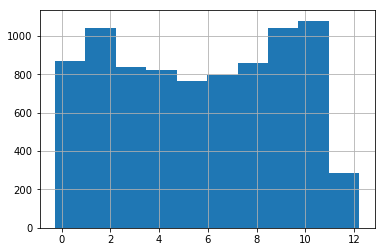

In [19]:
test['ans'].hist()

In [20]:
test['ans'].describe()

count    8409.000000
mean        5.696277
std         3.457993
min        -0.276554
25%         2.523626
50%         5.720650
75%         8.889917
max        12.215004
Name: ans, dtype: float64

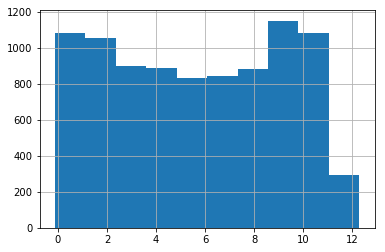

In [21]:
train['y'].hist()

In [22]:
train['y'].describe()

count    9000.000000
mean        5.695245
std         3.463744
min        -0.125144
25%         2.512812
50%         5.769032
75%         8.896220
max        12.288756
Name: y, dtype: float64